In [95]:
import pandas as pd

#import data

url = 'https://raw.githubusercontent.com/CarsenEssing/Essing-Carsen-ml-assignment-1/refs/heads/main/Data/morg-2014-emp.csv?token=GHSAT0AAAAAAC7FDH3TLOC36GVSTKDBQ53OZ6BZAHA'

df = pd.read_csv(url, low_memory=False)

print(df.head())
print(df.info())

   Unnamed: 0             hhid intmonth stfips     weight  earnwke  uhours  \
0           3    2600310997690  January     AL  3151.6801  1692.00      40   
1           5   75680310997590  January     AL  3457.1138   450.00      40   
2           6   75680310997590  January     AL  3936.9110  1090.00      60   
3          10  179140131100930  January     AL  3288.3640   769.23      40   
4          11  179140131100930  January     AL  3422.8500   826.92      40   

   grade92  race  ethnic  ...  ownchild  chldpres            prcitshp  state  \
0       43     1     NaN  ...         0         0  Native, Born In US     63   
1       41     2     NaN  ...         2         6  Native, Born In US     63   
2       41     2     NaN  ...         2         6  Native, Born In US     63   
3       40     1     NaN  ...         2         4  Native, Born In US     63   
4       43     1     NaN  ...         2         4  Native, Born In US     63   

                                               ind

In [96]:
#filter the dataset by computer programmers
occupation_code = 1010
df_filtered = df[df['occ2012'] == occupation_code]


#print("Number of rows", occupation_code, ":", len(df_filtered))
#print(df_filtered.head())

In [97]:
#print(df_filtered.describe())

# Model 1: Earnings per hour and age
### Predicts an individual's earnings per hour using only their age as a predictor.
* Age is often associated with work experience, skill development, and career progression, all of which can influence earnings
* Each additional year of age is linked to a specific change in earnings per hour (regression coefficient)

## RSME
* Full sample RMSE: 14.18
* Cross-validated RMSE: 14.23
* BIC: 4213.25

In [104]:
import statsmodels.api as sm
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


#calculate hourly earnings
df_filtered.loc[:, 'earnings_per_hour'] = df_filtered['earnwke'] / df_filtered['uhours']

#define age as the predictor
X = df_filtered[['age']]
y = df_filtered['earnings_per_hour']

X = sm.add_constant(X)

#fit
model1 = sm.OLS(y, X).fit()

print(model1.summary())

#RMSE
y_pred = model1.predict(X)
rmse_full = np.sqrt(np.mean((y - y_pred) ** 2))
print("Full sample RMSE:", rmse_full)

#cross-validated RMSE
X_cv = X.drop('const', axis=1)
lr = LinearRegression()

#cross-validation and negative mean squared error as scoring.
cv_scores = cross_val_score(lr, X_cv, y, cv=5, scoring='neg_mean_squared_error')
rmse_cv = np.sqrt(-np.mean(cv_scores))
print("Cross-validated RMSE:", rmse_cv)

# BIC
print("BIC:", model1.bic)


                            OLS Regression Results                            
Dep. Variable:      earnings_per_hour   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     40.28
Date:                Fri, 28 Feb 2025   Prob (F-statistic):           4.85e-10
Time:                        15:34:28   Log-Likelihood:                -2100.4
No. Observations:                 516   AIC:                             4205.
Df Residuals:                     514   BIC:                             4213.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.5200      2.430      8.032      0.0

# Model 2: Earnings per hour and age, education level, and gender
### including more predictors acknowledges that factors beyond age, such as educational attainment and gender, can have an impact on wages.
* Grade92: Represents the highest educational grade completed,key indicator of an individual's education level which can influence earnings
* Sex: Captures differences in earnings that may be associated with gender
  
### RSME
* Full sample RMSE: 13.65
* Cross-validated RMSE: 14.26
* BIC: 4186.59

In [106]:
X1 = df_filtered[['age', 'grade92', 'sex']]
y = df_filtered['earnings_per_hour']

X1 = sm.add_constant(X1)

#fit
model2 = sm.OLS(y, X1).fit()

print(model2.summary())

#Full Sample RMSE
rmse_full = np.sqrt(np.mean((y - y_pred) ** 2))
print("Full sample RMSE:", rmse_full)

#Cross-Validated RMSE:
X_cv = X.drop('const', axis=1)
lr = LinearRegression()
cv_scores = cross_val_score(lr, X_cv, y, cv=5, scoring='neg_mean_squared_error')
rmse_cv = np.sqrt(-np.mean(cv_scores))
print("Cross-validated RMSE:", rmse_cv)

#BIC in the full sample
bic = model2.bic
print("BIC:", bic)

                            OLS Regression Results                            
Dep. Variable:      earnings_per_hour   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     27.88
Date:                Fri, 28 Feb 2025   Prob (F-statistic):           1.03e-16
Time:                        15:34:31   Log-Likelihood:                -2080.8
No. Observations:                 516   AIC:                             4170.
Df Residuals:                     512   BIC:                             4187.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -62.8997     17.076     -3.684      0.0

# Model 3: Interaction term between age and aducation
## Adding an interaction term between age and education which captures the possibility that the effect of education on earnings per hour may change with age
* Multiplying age and grade92: tests whether the effect of education on earnings changes as individuals get older. See if higher education has larger wage benefits for older workers compared to younger workers, or vice versa.

### RSME
* Full sample RMSE: 13.59
* Cross-validated RMSE: 13.72
* BIC: 4188.62

In [109]:
df_filtered = df_filtered.copy()
df_filtered['age_grade92'] = df_filtered['age'] * df_filtered['grade92']

#interaction term: age * grade92
df_filtered['age_grade92'] = df_filtered['age'] * df_filtered['grade92']

#define predictors: age, grade92, sex, and the interaction term
X3 = df_filtered[['age', 'grade92', 'sex', 'age_grade92']]
y = df_filtered['earnings_per_hour']


X3 = sm.add_constant(X3)

#fit 
model3 = sm.OLS(y, X3).fit()

print(model3.summary())

#full Sample RMSE
y_pred = model3_option1.predict(X3_option1)
rmse_full = np.sqrt(np.mean((y - y_pred) ** 2))
print("Full sample RMSE for Model 3:", rmse_full)

# (2) Cross-Validated RMSE
X_cv = X3_option1.drop('const', axis=1)
lr = LinearRegression()
cv_scores = cross_val_score(lr, X_cv, y, cv=5, scoring='neg_mean_squared_error')
rmse_cv = np.sqrt(-np.mean(cv_scores))
print("Cross-validated RMSE for Model 3:", rmse_cv)

#BIC in the full sample
bic_model3 = model3_option1.bic
print("BIC for Model 3:", bic_model3)


                            OLS Regression Results                            
Dep. Variable:      earnings_per_hour   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     22.09
Date:                Fri, 28 Feb 2025   Prob (F-statistic):           7.75e-17
Time:                        15:34:34   Log-Likelihood:                -2078.7
No. Observations:                 516   AIC:                             4167.
Df Residuals:                     511   BIC:                             4189.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -177.9294     58.667     -3.033      

# Model 4: More interaction terms
## includes predictors: age, education, gender, and marital status and 2 new interaction terms.

* sex_grade92: Captures whether the effect of education on earnings per hour differs by gender. The returns to education might be higher for one gender compared to the other
* age_marital: Captures whether the effect of age on earnings per hour varies by marital status. Marital status might impact work-life balance or stability, which can interact with how age influences earnings

### RSME
* Full sample RMSE: 13.44
* Cross-validated RMSE: 13.61
* BIC: 4189.28


In [112]:
df_filtered = df_filtered.copy()

#create interaction terms:
df_filtered['sex_grade92'] = df_filtered['sex'] * df_filtered['grade92']
df_filtered['age_marital'] = df_filtered['age'] * df_filtered['marital']

#define predictors for option 2
X4 = df_filtered[['age', 'grade92', 'sex', 'marital', 'sex_grade92', 'age_marital']]
y = df_filtered['earnings_per_hour']

#add constant for the intercept
X4 = sm.add_constant(X4)

#fit
model4 = sm.OLS(y, X4).fit()

print(model4.summary())

#Full Sample RMSE:
y_pred = model4.predict(X4)
rmse_full = np.sqrt(np.mean((y - y_pred) ** 2))
print("Full sample RMSE for Model 4:", rmse_full)


#Cross-Validated RMSE:
X_cv = X4.drop('const', axis=1)
lr = LinearRegression()
cv_scores = cross_val_score(lr, X_cv, y, cv=5, scoring='neg_mean_squared_error')
rmse_cv = np.sqrt(-np.mean(cv_scores))
print("Cross-validated RMSE for Model 4:", rmse_cv)

#BIC in the full sample:

print("BIC for Model 4:", model4.bic)


                            OLS Regression Results                            
Dep. Variable:      earnings_per_hour   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     16.98
Date:                Fri, 28 Feb 2025   Prob (F-statistic):           6.51e-18
Time:                        15:34:37   Log-Likelihood:                -2072.8
No. Observations:                 516   AIC:                             4160.
Df Residuals:                     509   BIC:                             4189.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -8.4708     52.752     -0.161      

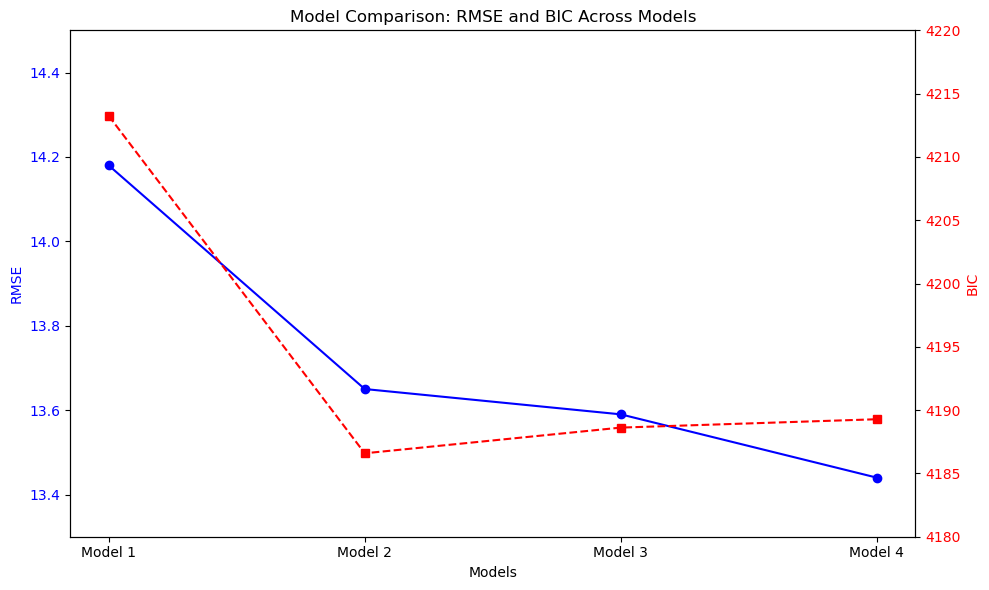

In [124]:
import matplotlib.pyplot as plt

#data summary
models = ['Model 1', 'Model 2', 'Model 3', 'Model 4']
rmse_full = [14.18, 13.65, 13.59, 13.44]
bic = [4213.25, 4186.59, 4188.62, 4189.28]

fig, ax1 = plt.subplots(figsize=(10, 6))

#plot RMSE 
ax1.plot(models, rmse_full, marker='o', linestyle='-', color='blue', label='Full Sample RMSE')
ax1.set_xlabel('Models')
ax1.set_ylabel('RMSE', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim([13.3, 14.5]) 

#second y-axis for BIC
ax2 = ax1.twinx()
ax2.plot(models, bic, marker='s', linestyle='--', color='red', label='BIC')
ax2.set_ylabel('BIC', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim([4180, 4220]) 


plt.title('Model Comparison: RMSE and BIC Across Models')
fig.tight_layout()
plt.show()
